## Predict category of Products from consumer complaints

#### Import all necessary libraries

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:
df = pd.read_csv('Consumer_Complaints.csv')

In [4]:
df.head()

Date received                      Product  \
0    03/12/2014                     Mortgage   
1    01/19/2017                 Student loan   
2    04/06/2018  Credit card or prepaid card   
3    06/08/2014                  Credit card   
4    09/13/2014              Debt collection   

                                  Sub-product  \
0                              Other mortgage   
1              Federal student loan servicing   
2  General-purpose credit card or charge card   
3                                         NaN   
4                                 Credit card   

                                      Issue  \
0  Loan modification,collection,foreclosure   
1        Dealing with my lender or servicer   
2        Other features, terms, or problems   
3                                Bankruptcy   
4                     Communication tactics   

                                Sub-issue  \
0                                     NaN   
1  Received bad information about my loan   
2                           Other problem   
3                                     NaN   
4              Frequent or repeated calls   

                        Consumer complaint narrative Company public response  \
0                                                NaN                     NaN   
1  When my loan was switched over to Navient i wa...                     NaN   
2  I tried to sign up for a spending monitoring p...                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   

                             Company State ZIP code            Tags  \
0               M&T BANK CORPORATION    MI    48382             NaN   
1            Navient Solutions, LLC.    LA      NaN             NaN   
2  CAPITAL ONE FINANCIAL CORPORATION    VA      NaN  Older American   
3           AMERICAN EXPRESS COMPANY    ID    83854  Older American   
4                     CITIBANK, N.A.    VA    23233             NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0                        NaN      Referral           03/17/2014   
1           Consent provided           Web           01/19/2017   
2           Consent provided           Web           04/06/2018   
3                        NaN           Web           06/10/2014   
4                        NaN           Web           09/13/2014   

  Company response to consumer Timely response? Consumer disputed?  \
0      Closed with explanation              Yes                 No   
1      Closed with explanation              Yes                 No   
2      Closed with explanation              Yes                NaN   
3      Closed with explanation              Yes                Yes   
4      Closed with explanation              Yes                Yes   

   Complaint ID  
0        759217  
1       2296496  
2       2866101  
3        885638  
4       1027760

In [5]:
df.shape

(1144848, 18)

In [6]:
df = df[['Product', 'Consumer complaint narrative']]

In [7]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [8]:
df.shape

(332361, 2)

In [9]:
df = df.reset_index(drop=True)

In [10]:
df.columns = ['Product', 'narrative']
# or could have done this
# df.rename(columns={'Consumer complaint narrative': 'narrative'}, inplace=True)

In [11]:
df.isnull().sum()

Product      0
narrative    0
dtype: int64

In [12]:
df['Product'].value_counts()

Debt collection                                                                 76097
Credit reporting, credit repair services, or other personal consumer reports    70636
Mortgage                                                                        48779
Credit reporting                                                                31588
Student loan                                                                    19273
Credit card                                                                     18838
Credit card or prepaid card                                                     16178
Bank account or service                                                         14885
Checking or savings account                                                      9639
Consumer Loan                                                                    9473
Money transfer, virtual currency, or money service                               4405
Vehicle loan or lease                                 

#### Check class balancing

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


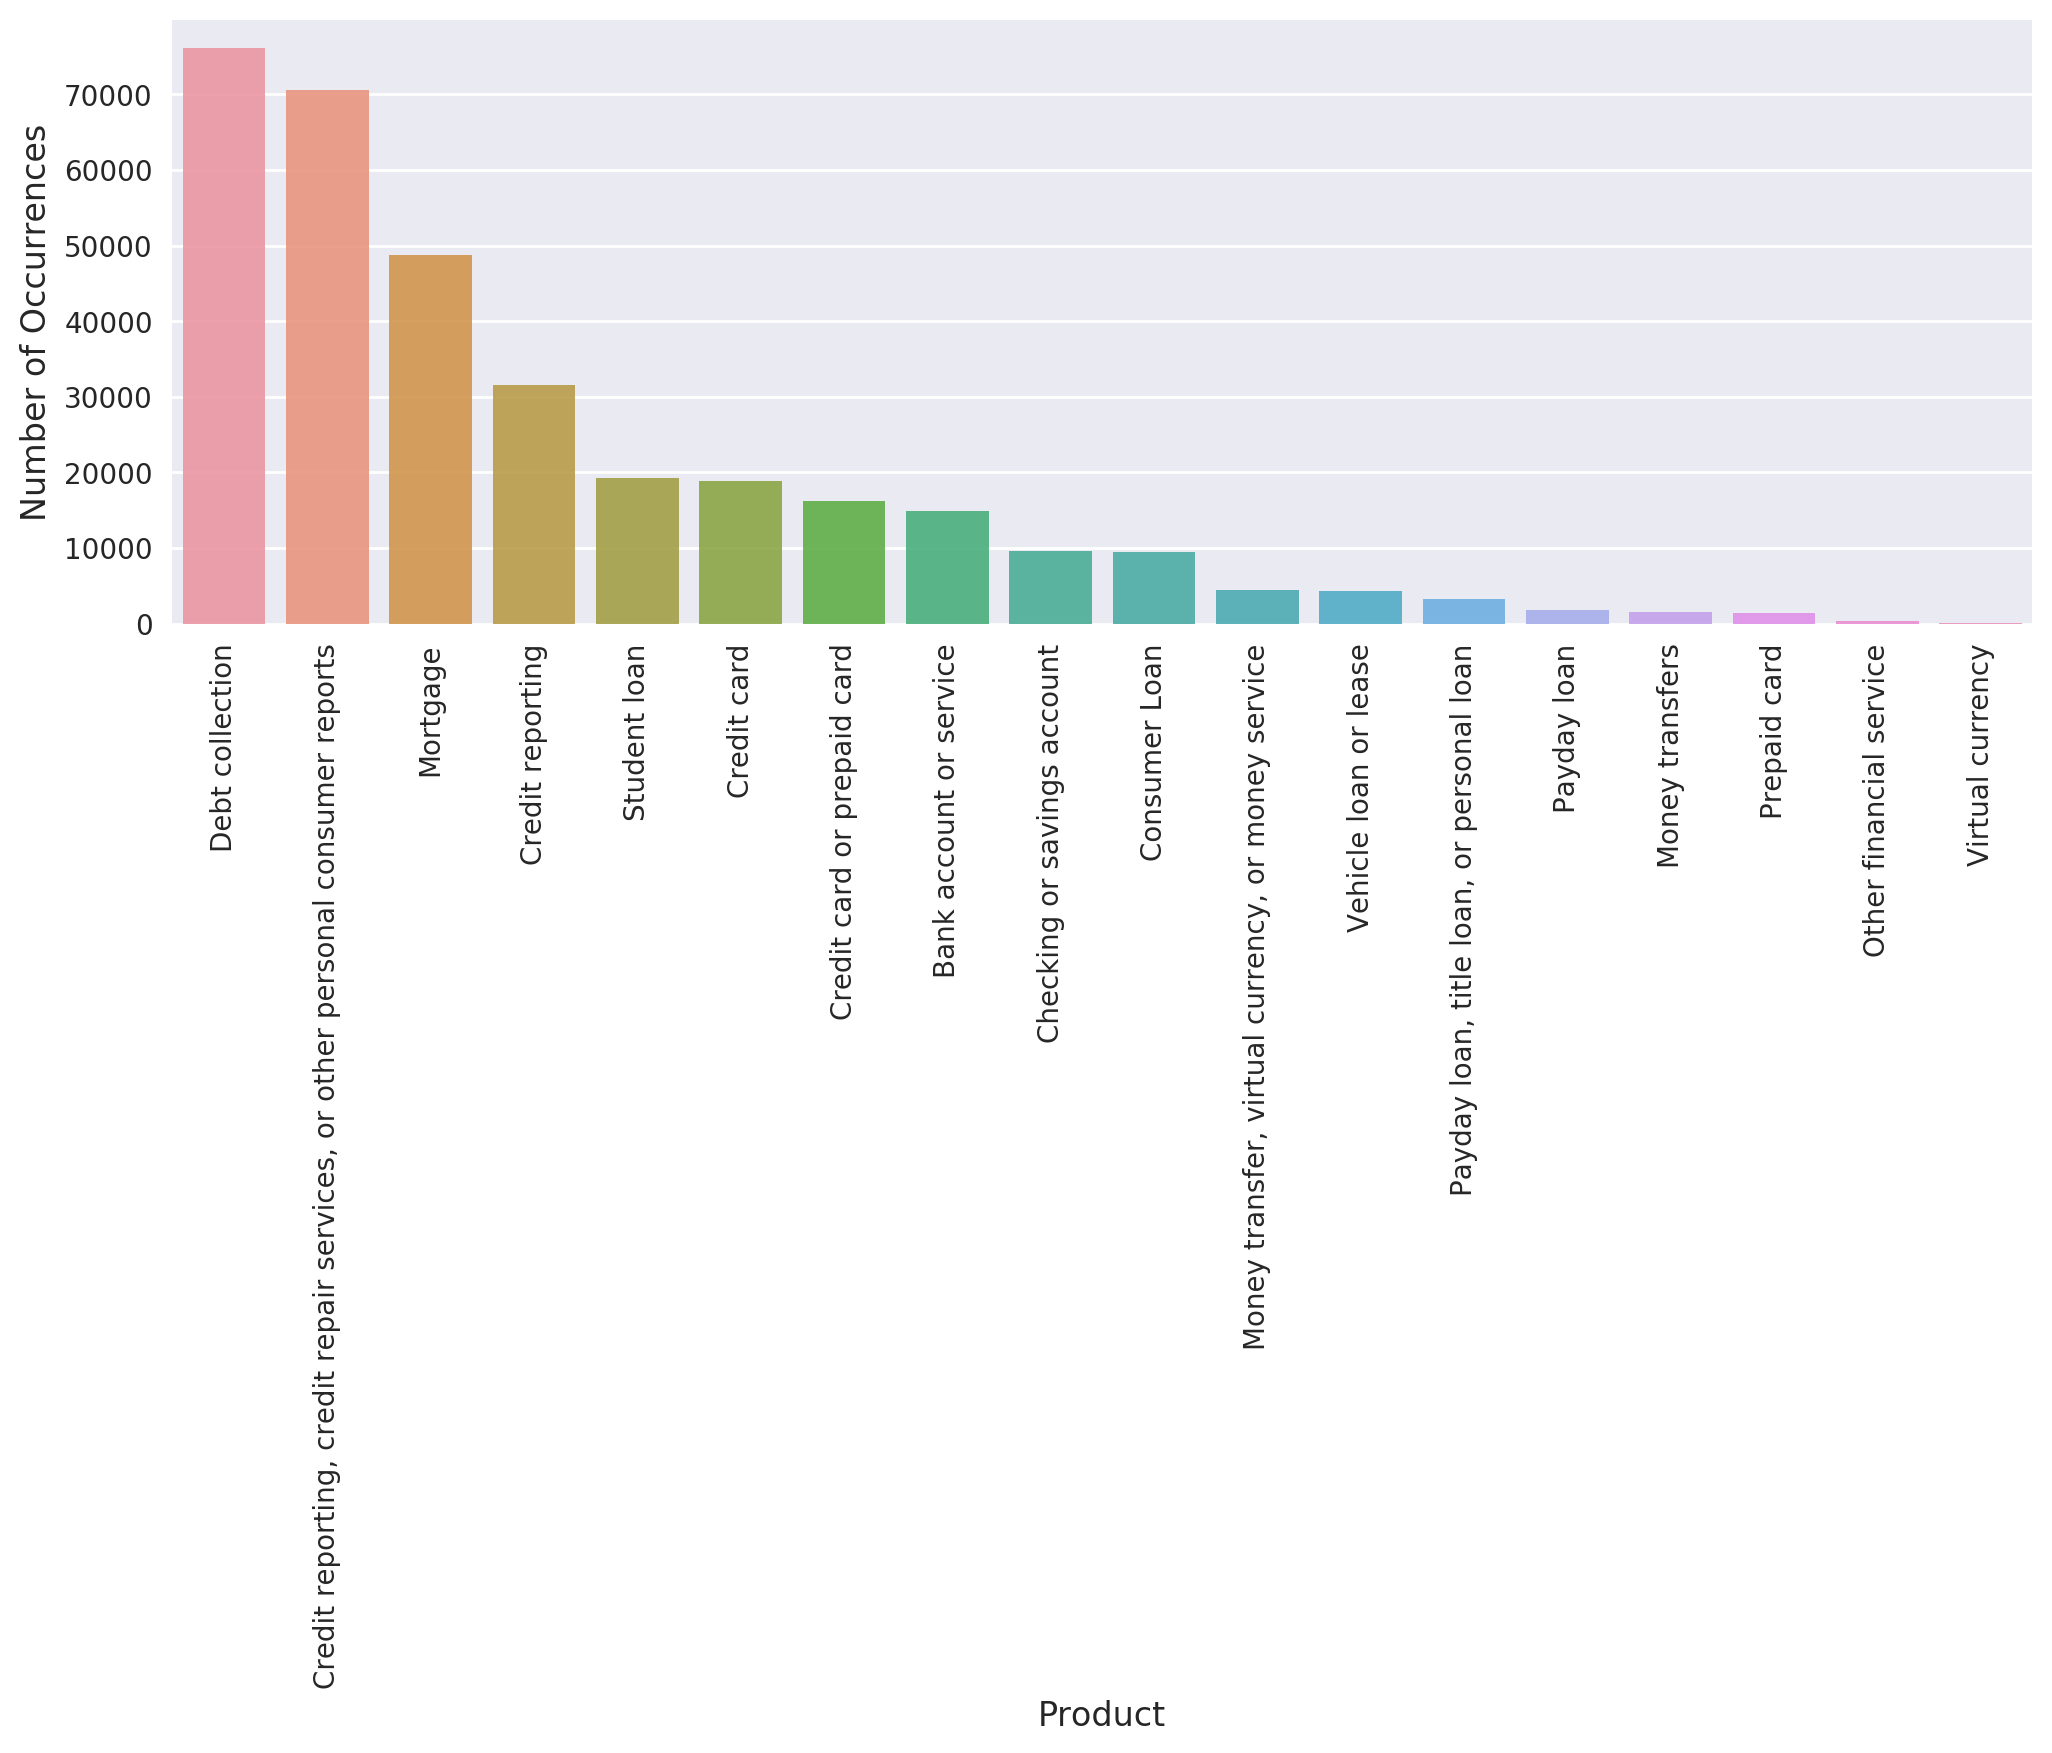

In [13]:
product_counts = df['Product'].value_counts()

plt.figure(figsize=(12,4), dpi=200)
sns.barplot(product_counts.index, product_counts.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
## Imbalanced classes ---> Oversampling/Undersampling should be tried. We will do it later, for now let's go ahead
# with imbalanced data and see how it performs

#### Check how complaints normally look like

In [14]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [15]:
print_complaint(100)

Met with  XXXX  "  XXXX  ''  XXXX  personal banker a t Wells Fargo   XXXX   XXXX   XXXX   XXXX   XXXX   XXXX , Fl. Phone #  XXXX . Went to the bank to get a  XXXX  stamp to make an assignment of a loan to a mutual fund. I was told that I could not get the stamp because the owner of the assignment was not a bank client. I was told th at Wells Fargo could not stamp the document because the person is not known to the bank. This transaction was the purchase of a car, Wells Fargo do es advertise this service to the public and does not state that it is only for bank clients.
('Product:', 'Money transfer, virtual currency, or money service')


In [16]:
print_complaint(35000)

I was unable to pay my payday loan with cash express in XXXX ky. Even after I tried to set up a payment with them, they have called every day. even had a collection agencency call. I was suppose to be able to set up a payment with them. Now cash express is saying I cant make payments. They was at my door this morning to collect.. Not sure if its illegal to harass people at there residents. But this is very over whelming. Please let me know what I need to do?
('Product:', 'Debt collection')


### Label product category and create map text to numeric and vice versa

In [17]:
df['category_id'] = df['Product'].factorize()[0]

In [18]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

In [19]:
category_id_df

Product  category_id
0                                           Student loan            0
1                            Credit card or prepaid card            1
2                                               Mortgage            2
4                                       Credit reporting            3
5      Credit reporting, credit repair services, or o...            4
8                                        Debt collection            5
16                                 Vehicle loan or lease            6
20     Money transfer, virtual currency, or money ser...            7
21                           Checking or savings account            8
61             Payday loan, title loan, or personal loan            9
63                                         Consumer Loan           10
84                               Bank account or service           11
88                                           Credit card           12
345                                      Money transfers           13
408                                         Prepaid card           14
562                                          Payday loan           15
2527                             Other financial service           16
10539                                   Virtual currency           17

In [20]:
category_to_id = dict(category_id_df.values)

In [21]:
category_to_id

{'Bank account or service': 11,
 'Checking or savings account': 8,
 'Consumer Loan': 10,
 'Credit card': 12,
 'Credit card or prepaid card': 1,
 'Credit reporting': 3,
 'Credit reporting, credit repair services, or other personal consumer reports': 4,
 'Debt collection': 5,
 'Money transfer, virtual currency, or money service': 7,
 'Money transfers': 13,
 'Mortgage': 2,
 'Other financial service': 16,
 'Payday loan': 15,
 'Payday loan, title loan, or personal loan': 9,
 'Prepaid card': 14,
 'Student loan': 0,
 'Vehicle loan or lease': 6,
 'Virtual currency': 17}

In [22]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [23]:
id_to_category

{0: 'Student loan',
 1: 'Credit card or prepaid card',
 2: 'Mortgage',
 3: 'Credit reporting',
 4: 'Credit reporting, credit repair services, or other personal consumer reports',
 5: 'Debt collection',
 6: 'Vehicle loan or lease',
 7: 'Money transfer, virtual currency, or money service',
 8: 'Checking or savings account',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Consumer Loan',
 11: 'Bank account or service',
 12: 'Credit card',
 13: 'Money transfers',
 14: 'Prepaid card',
 15: 'Payday loan',
 16: 'Other financial service',
 17: 'Virtual currency'}

In [24]:
df.head()

Product  \
0                 Student loan   
1  Credit card or prepaid card   
2                     Mortgage   
3                     Mortgage   
4             Credit reporting   

                                           narrative  category_id  
0  When my loan was switched over to Navient i wa...            0  
1  I tried to sign up for a spending monitoring p...            1  
2  My mortgage is with BB & T Bank, recently I ha...            2  
3  The entire lending experience with Citizens Ba...            2  
4  My credit score has gone down XXXX points in t...            3

###  TEXT CLEANING

In [25]:
def clean_str(text):
    cleantext = re.sub(r"[^A-Za-z.!?]", " ", str(text))  # remove everything but letters and EOL
    cleantext = re.sub(r"\d+\.\d", " ", cleantext)  # remove decimal numbers
    cleantext = re.sub(r"\b\d+\b", " ", cleantext)  # remove any number between two words
    cleantext = re.sub(r"[X]{2,}", " ", cleantext)  # remove XXXX type imputations
    cleantext = re.sub(r"[.]{2,}", " ", cleantext)
    cleantext = re.sub(r"\s{2,}", " ", cleantext)  # remove extra white spaces
    return cleantext.strip().lower()

In [26]:
i = 100
print "----- Original text ------\n"
print df['narrative'][i]
print "\n---- Cleaned text ----\n"
print clean_str(df['narrative'][i])
print "\n Product --> ", df['Product'][i]

----- Original text ------

Met with  XXXX  "  XXXX  ''  XXXX  personal banker a t Wells Fargo   XXXX   XXXX   XXXX   XXXX   XXXX   XXXX , Fl. Phone #  XXXX . Went to the bank to get a  XXXX  stamp to make an assignment of a loan to a mutual fund. I was told that I could not get the stamp because the owner of the assignment was not a bank client. I was told th at Wells Fargo could not stamp the document because the person is not known to the bank. This transaction was the purchase of a car, Wells Fargo do es advertise this service to the public and does not state that it is only for bank clients.

---- Cleaned text ----

met with personal banker a t wells fargo fl. phone . went to the bank to get a stamp to make an assignment of a loan to a mutual fund. i was told that i could not get the stamp because the owner of the assignment was not a bank client. i was told th at wells fargo could not stamp the document because the person is not known to the bank. this transaction was the purchas

In [27]:
st = time.time()
df_cleaned = df
df_cleaned['narrative'] = df_cleaned['narrative'].apply(clean_str)
et = time.time()
print "Time taken to clean narratives = ", et-st

Time taken to clean narratives =  50.9926879406


### Split into training and testing set

In [28]:
train, test = train_test_split(df_cleaned, test_size=0.3, random_state=42)

In [29]:
train_counts = train['Product'].value_counts()
test_counts = test['Product'].value_counts()

In [30]:
train_counts/test_counts

Bank account or service                                                         2.245040
Checking or savings account                                                     2.418085
Consumer Loan                                                                   2.332044
Credit card                                                                     2.328857
Credit card or prepaid card                                                     2.367610
Credit reporting                                                                2.325053
Credit reporting, credit repair services, or other personal consumer reports    2.337870
Debt collection                                                                 2.342279
Money transfer, virtual currency, or money service                              2.430685
Money transfers                                                                 2.326667
Mortgage                                                                        2.318977
Other financial servi

### Stratified sampling

In [31]:
from sklearn import cross_validation
skf = cross_validation.StratifiedShuffleSplit(df_cleaned['Product'], 1, test_size=0.3, random_state=42)

/mnt/ebs1/nagarwal/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
for train_index, test_index in skf:
    train_skf = df_cleaned.ix[train_index,]
    test_skf = df_cleaned.ix[test_index,]

In [33]:
train_skf['Product'].value_counts() / test_skf['Product'].value_counts()

Debt collection                                                                 2.333348
Credit reporting, credit repair services, or other personal consumer reports    2.333302
Mortgage                                                                        2.333265
Credit reporting                                                                2.333474
Student loan                                                                    2.333276
Credit card                                                                     2.333569
Credit card or prepaid card                                                     2.333608
Bank account or service                                                         2.332960
Checking or savings account                                                     2.332988
Consumer Loan                                                                   2.333216
Money transfer, virtual currency, or money service                              2.332073
Vehicle loan or lease

### TF-IDF 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum number of documents a term must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.


/mnt/ebs1/nagarwal/.local/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hashing


### This wil throw OOM error

In [ ]:
st = time.time()
features = tfidf.fit_transform(train_skf['narrative']).toarray()
et = time.time()
print "Time taken to create TF-IDF vectors = ", et-st

#### Reduce data set size for simplicity

In [35]:
cat_ids = list()
for product in train_skf['Product'].value_counts().head(5).index:
    cat_ids.append(category_to_id[product])

In [36]:
cat_ids

[5, 4, 2, 3, 0]

In [37]:
subset_df = df_cleaned[df_cleaned['category_id'].isin(cat_ids)]

In [49]:
# Include just 50% of subset_df. Num rows should be around 120k. Then split this into train and test, with test_ratio of 0.4
subset_df.reset_index(drop=True, inplace=True)
skf_small = cross_validation.StratifiedShuffleSplit(subset_df['Product'], 1, test_size=0.90, random_state=42)
for small_index, oom_index in skf_small:
    small_df = subset_df.ix[small_index,]
    oom_df = subset_df.ix[oom_index,]

In [50]:
small_df.shape

(24637, 3)

### Now split into train and test

In [51]:
small_df.reset_index(drop=True, inplace=True)
skf_final = cross_validation.StratifiedShuffleSplit(small_df['Product'], 1, test_size=0.4, random_state=42)
for train_idx, test_idx in skf_final:
    train_final = small_df.ix[train_idx,]
    test_final = small_df.ix[test_idx,]

In [52]:
train_final['Product'].value_counts()

Debt collection                                                                 4566
Credit reporting, credit repair services, or other personal consumer reports    4238
Mortgage                                                                        2927
Credit reporting                                                                1895
Student loan                                                                    1156
Name: Product, dtype: int64

### Try TF-IDF now

In [91]:
st = time.time()
features = tfidf.fit_transform(train_final['narrative']).toarray()  # This is our X_train
et = time.time()
print "Time taken to create TF-IDF vectors = ", et-st

Time taken to create TF-IDF vectors =  6.89865994453


In [54]:
features.shape

(14782, 34948)

In [55]:
labels = train_final.category_id # This is target variable

In [56]:
cat_to_id_final = {id_to_category[k]: k for k in cat_ids}

In [57]:
cat_to_id_final

{'Credit reporting': 3,
 'Credit reporting, credit repair services, or other personal consumer reports': 4,
 'Debt collection': 5,
 'Mortgage': 2,
 'Student loan': 0}

In [68]:
id_to_cat_final = {cat_to_id_final[i]: i for i in cat_to_id_final}

In [69]:
id_to_cat_final

{0: 'Student loan',
 2: 'Mortgage',
 3: 'Credit reporting',
 4: 'Credit reporting, credit repair services, or other personal consumer reports',
 5: 'Debt collection'}

In [ ]:
final_

In [59]:
from sklearn.feature_selection import chi2
st = time.time()
N = 3
for product, category_id in sorted(cat_to_id_final.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("### '{}':".format(product))
    print(" -- Most correlated unigrams: -- \n {}".format('\n '.join(unigrams[-N:])))
    print(" -- Most correlated bigrams: -- \n {}".format('\n '.join(bigrams[-N:])))
et = time.time()
print "Time taken = ", et-st

### 'Credit reporting':
 -- Most correlated unigrams: -- 
 transunion
 equifax
 experian
 -- Most correlated bigrams: -- 
 tax lien
 trans union
 credit report
### 'Credit reporting, credit repair services, or other personal consumer reports':
 -- Most correlated unigrams: -- 
 equifax
 inquiry
 inquiries
 -- Most correlated bigrams: -- 
 mistakes appear
 appear report
 report understanding
### 'Debt collection':
 -- Most correlated unigrams: -- 
 collect
 collection
 debt
 -- Most correlated bigrams: -- 
 debt collection
 collection agency
 collect debt
### 'Mortgage':
 -- Most correlated unigrams: -- 
 escrow
 modification
 mortgage
 -- Most correlated bigrams: -- 
 mortgage company
 wells fargo
 loan modification
### 'Student loan':
 -- Most correlated unigrams: -- 
 student
 loans
 navient
 -- Most correlated bigrams: -- 
 income based
 student loans
 student loan
Time taken =  9.23242306709


## Multi Class Classification models

### Naive Bayes Classifier

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [70]:
train_final.reset_index(drop=True, inplace=True)
test_final.reset_index(drop=True, inplace=True)

In [61]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_final['narrative'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = train_final['category_id']
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [75]:
def validate_prediction(num):
    narr = test_final.ix[num,'narrative']
    actual_y = test_final.ix[num, 'Product']
    predicted_y = clf.predict(tfidf_transformer.transform(count_vect.transform([narr])))[0]
    print "--- Narrative --- "
    print narr
    print "--- Actual Product ---"
    print actual_y
    print "--- Predicted Product ---"
    print id_to_cat_final[predicted_y]

In [86]:
validate_prediction(125)

--- Narrative --- 
i had made a deal with a credit card company to have fund taken out of my checking acct of a month until it was paid so they took out payment then sold to a collection agencythen took more payments of the same amount this was a card at the time i made the deal i had like before theyhad late fees over the limit fee how can i be over my limit when i have maid payments now i have all paper work they took payment after they sold the note. now they are going to garnish my pay for
--- Actual Product ---
Debt collection
--- Predicted Product ---
Debt collection


### Model Selection

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

In [90]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

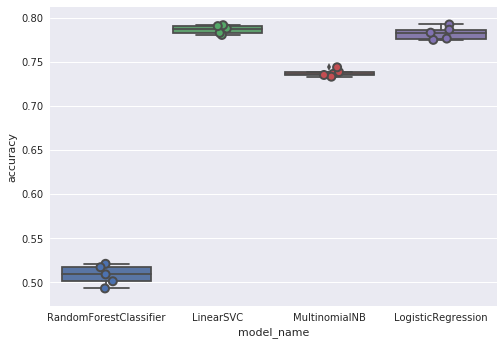

In [92]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [93]:
cv_df

model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.493072
1   RandomForestClassifier         1  0.501184
2   RandomForestClassifier         2  0.520974
3   RandomForestClassifier         3  0.517090
4   RandomForestClassifier         4  0.508968
5                LinearSVC         0  0.787766
6                LinearSVC         1  0.780521
7                LinearSVC         2  0.782815
8                LinearSVC         3  0.791540
9                LinearSVC         4  0.790525
10           MultinomialNB         0  0.736397
11           MultinomialNB         1  0.733176
12           MultinomialNB         2  0.735115
13           MultinomialNB         3  0.738409
14           MultinomialNB         4  0.743824
15      LogisticRegression         0  0.774924
16      LogisticRegression         1  0.792357
17      LogisticRegression         2  0.776387
18      LogisticRegression         3  0.783080
19      LogisticRegression         4  0.786464

In [95]:
cv_df.groupby('model_name')['accuracy'].mean()

model_name
LinearSVC                 0.786633
LogisticRegression        0.782642
MultinomialNB             0.737384
RandomForestClassifier    0.508257
Name: accuracy, dtype: float64

In [96]:
## Linear SVC and Logistic, both have performed equally well and better than RF/NB

### Model Evaluation

### SVC

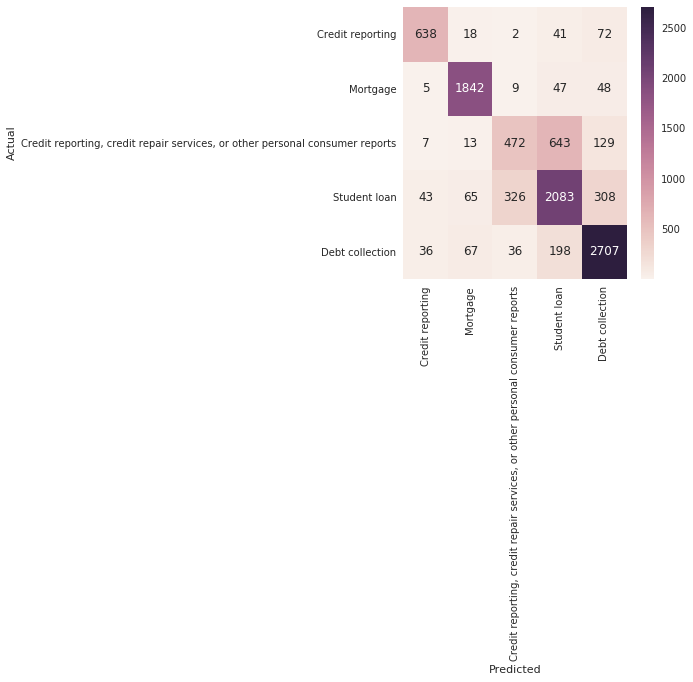

In [110]:
model_svc = LinearSVC()
model_svc.fit(features, labels)

features_test = tfidf.transform(test_final['narrative']).toarray()

labels_test = test_final['category_id']

y_pred_svc = model_svc.predict(features_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels_test, y_pred_svc)

final_category_id_df = train_final[['Product', 'category_id']].drop_duplicates().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=final_category_id_df.Product.values, yticklabels=final_category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
## The vast majority of the predictions end up on the diagonal (predicted label = actual label), 
## where we want them to be. 
##  However, there are a number of misclassifications, and it might be interesting to see what those are caused by

In [111]:
from sklearn import metrics
print(metrics.classification_report(labels_test, y_pred_svc, target_names=final_category_id_df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.88      0.83      0.85       771
                                                                    Mortgage       0.92      0.94      0.93      1951
Credit reporting, credit repair services, or other personal consumer reports       0.56      0.37      0.45      1264
                                                                Student loan       0.69      0.74      0.71      2825
                                                             Debt collection       0.83      0.89      0.86      3044

                                                                 avg / total       0.78      0.79      0.78      9855



### Logistic

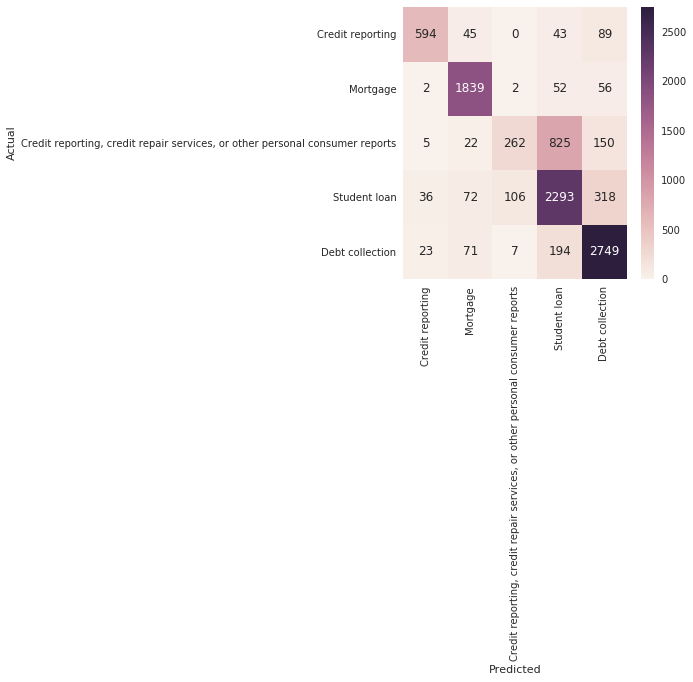

In [112]:
model_log = LogisticRegression()
model_log.fit(features, labels)

y_pred_log = model_log.predict(features_test)

conf_mat = confusion_matrix(labels_test, y_pred_log)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=final_category_id_df.Product.values, yticklabels=final_category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()